# Analyzing Oil Futures Market

The goal is to quantitative insights into crude oil price behavior and market dynamics, to support trading decisions and risk management.

In [2]:
#importing base packages
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

Current Stauts

1. Find relevant data and process it - DONE

2. Price & Volatility Analysis - DONE

- Analyze historical price trends using continuous futures data (daily OHLC)

- Calculate rolling volatility (e.g., 30-day, 90-day) and identify volatility regimes

- Compute return distributions over different time scales (daily, weekly, monthly)

3. Roll Yield Approximation - INTERRUPTED DUE TO ABSENCE OF DATA

- Estimate roll yield behavior using price changes in continuous futures

- Understand impact of contango/backwardation dynamics indirectly from data

4. Event Studies - TO DO

- Identify seasonal patterns and correlations with key economic events

- Analyze price/volatility reaction around major oil market events (OPEC meetings, geopolitical shocks)

5. Strategy Development & Backtesting - TO DO

- Prototype simple trading or hedging strategies (momentum, mean reversion, volatility breakout) based on continuous futures data

- Backtest strategies and evaluate performance metrics (returns, Sharpe ratio, drawdown)

6. Reporting & Visualization -TO DO

- Create dashboards or notebooks to visualize key insights (price, volatility, returns, event impacts)

- Summarize findings in clear, business-oriented reports with actionable recommendations

## Data Retrieving and Processing

In [19]:
#use a script created to fetch yfinance data

#get to the path

#check where the script function is located
import os
print(os.getcwd())

import sys
import os

# scripts folder absolute path based on current working directory
scripts_path = os.path.abspath("scripts")
print("Scripts folder absolute path:", scripts_path)

# add it to sys.path so Python can find modules there
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

from fetch_yf_data import fetch_data

#now we can call fetch_data to get data from yf API

c:\Users\dgalassi\commodity_lab
Scripts folder absolute path: c:\Users\dgalassi\commodity_lab\scripts


In [20]:
#define the ticker/tickers we want to extract. For now only oil futures (CL=F)

#inputs to the function
tickers = {'Oil':'CL=F'}
period = '20y' # 20 years of data
interval = '1d' #we want daily timeframe

data = fetch_data(tickers,period=period,interval=interval)

Fetching  data for Oil (CL=F) - Period: 20y, Interval: 1d


c:\Users\dgalassi\commodity_lab\scripts\fetch_yf_data.py:34: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed


In [21]:
#now we extracted the data from yf.
#the script created will extract and automatically format it into a nice table with colums

#some stuff so that the user can have an idea of what the data is about
column_names = []
for col in data.columns:
    column_names.append(col)

print('---------------- Main info about the data ----------------')

print(f'The dataframe has {data.shape[0]} rows and {data.shape[1]} columns ')
print(f'The dataframe spans from {data.date.iloc[0]} to {data.date.iloc[-1]} with timeframe of {interval[0]} day')
print(f'The dataframe contains the following columns:{column_names}')

print('----------------------------------------------------------')

print('You can visualize the first rows of the Dataframe...')
data.head()

---------------- Main info about the data ----------------
The dataframe has 5030 rows and 10 columns 
The dataframe spans from 2005-07-25 00:00:00 to 2025-07-23 00:00:00 with timeframe of 1 day
The dataframe contains the following columns:['date', 'open', 'high', 'low', 'close', 'volume', 'name', 'ticker', 'source', 'timeframe']
----------------------------------------------------------
You can visualize the first rows of the Dataframe...


,date,open,high,low,close,volume,name,ticker,source,timeframe
0,2005-07-25,58.750000,59.070000,57.650002,59.000000,78479,Oil,CL=F,yfinance,1d
1,2005-07-26,59.099998,59.880001,58.500000,59.200001,86851,Oil,CL=F,yfinance,1d
2,2005-07-27,59.150002,59.700001,58.599998,59.110001,93281,Oil,CL=F,yfinance,1d
3,2005-07-28,59.209999,60.150002,58.799999,59.939999,83720,Oil,CL=F,yfinance,1d
4,2005-07-29,59.930000,61.049999,59.810001,60.570000,100656,Oil,CL=F,yfinance,1d


## Price & Volatility Analysis

The main goal of this substage is to check the price and volatility evolution, and the distribution of returns over different timeframes

In [22]:
#now let's only keep what we need
print('------------ Reduce to necessary data ---------------')


df = data.drop(['ticker','source','timeframe','open','low','high','name'],axis=1)

print(f'Make sure there are no missing data ...')
print(f'{df.isna().sum()}')

df.head()

------------ Reduce to necessary data ---------------
Make sure there are no missing data ...
date      0
close     0
volume    0
dtype: int64


,date,close,volume
0,2005-07-25,59.000000,78479
1,2005-07-26,59.200001,86851
2,2005-07-27,59.110001,93281
3,2005-07-28,59.939999,83720
4,2005-07-29,60.570000,100656


Text(0.5, 1.0, 'WTI Futures Closing Daily Price')

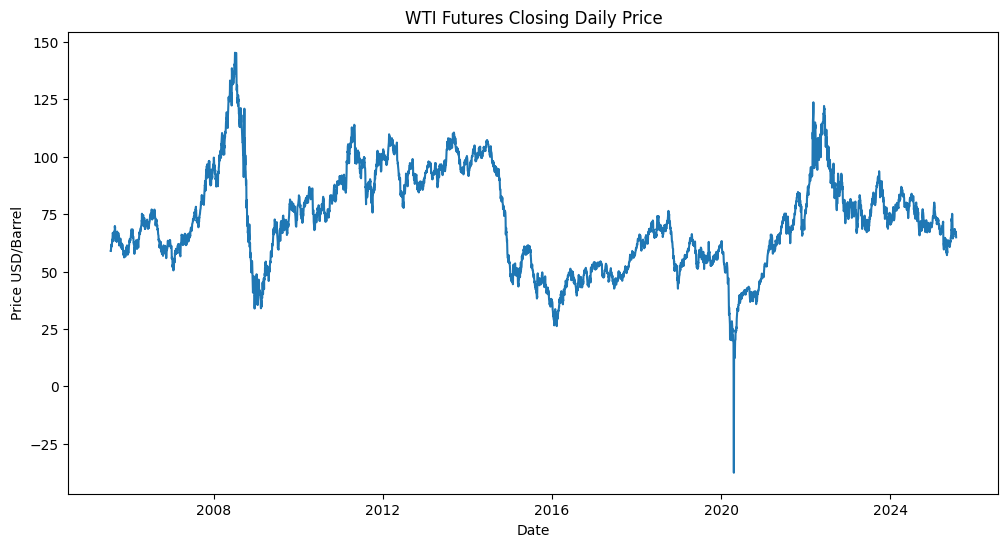

In [23]:
# oil price trend 
plt.figure(figsize=(12,6))
plt.plot(df.date,df.close)
plt.xlabel('Date')
plt.ylabel('Price USD/Barrel')
plt.title('WTI Futures Closing Daily Price')

By observing this plot we realize that during COvid-19 Oil Shock future prices went below 0 USD/Barrel. Is this even a thing?

Normally speaking, when we analyze price movements of bonds or equities, an asset price can't go below zero. This is not true for futures. Future prices, especially for physical commodities, take into account the cost of carry. This cost represents the cost of storing a given commodity, plus the interest paid on the storage plus eventual insurances that seller has to stipulate to cover any potential risk. 

So a future price below zero means that sellers were literally paying buyers to take oil off their reserves. This means that buyers could get the underlying and money to take the oil itself.

This happened for the following reasons?

- Massive oversupply (mostly due to a demand shortage)
- Noone wanted the underlying to be delivered and the contract was about to expire 
- Storage full
- Thin liquidity as most traders already rolled over the next contract 


Later on we could focus on specific events and draw some insighful concluslion!

Right now for math purposed we need to cut out all data where price are negative. We will replace them by price == 1 USD/Barrel (if we put zero the logs are freaking out!!!!!)


In [24]:
#drop these terrible indexxxxxxxes :)
rows_to_drop = df[df.close <=1]
print(f'The row to drop is the one corresponding to index {rows_to_drop.index[0]}')
df = df.drop(index=rows_to_drop.index)

The row to drop is the one corresponding to index 3706


In [25]:
# Daily (dr), Weekly (wr), Monthly (mr), Querterly (qr), and Yearly (yr) Returns
df['dr'] = np.log(df.close/df.close.shift(1))
df['wr'] = np.log(df.close/df.close.shift(5))
df['mr'] = np.log(df.close/df.close.shift(21))
df['qr'] = np.log(df.close/df.close.shift(63))
df['yr'] = np.log(df.close/df.close.shift(252))

returns = df[['dr','wr','mr','qr','yr']]
print(f'-------------- Main Statistics for Daily (dr), Weekly (wr), Monthly (mr), Quarterly (qr), and Yearly (yr) Returns ----------------')
returns.describe()

-------------- Main Statistics for Daily (dr), Weekly (wr), Monthly (mr), Quarterly (qr), and Yearly (yr) Returns ----------------


,dr,wr,mr,qr,yr
count,5028.000000,5024.000000,5008.000000,4966.000000,4777.000000
mean,0.000019,0.000112,0.000249,0.000051,0.003067
std,0.027593,0.057411,0.119172,0.220145,0.375666
min,-0.601676,-0.805923,-0.938142,-1.766126,-1.855298
25%,-0.012388,-0.027694,-0.059244,-0.088688,-0.187330
50%,0.000953,0.003228,0.009817,0.021174,0.020343
75%,0.012886,0.030881,0.068227,0.122469,0.208162
max,0.319634,0.688273,1.207662,1.433132,1.813011


As we discussed before we can observe that the minimum returns are way below -100% due to the pandemic demand driven shock. We can also notice that, as expected, oil can't be considered an asset to buy and hold as the median and mean returns are very low. Lately we will analyze more in depth the returns distributions for different time horizions

Text(0.5, 1.0, 'Monthly Price Log Returns (%)')

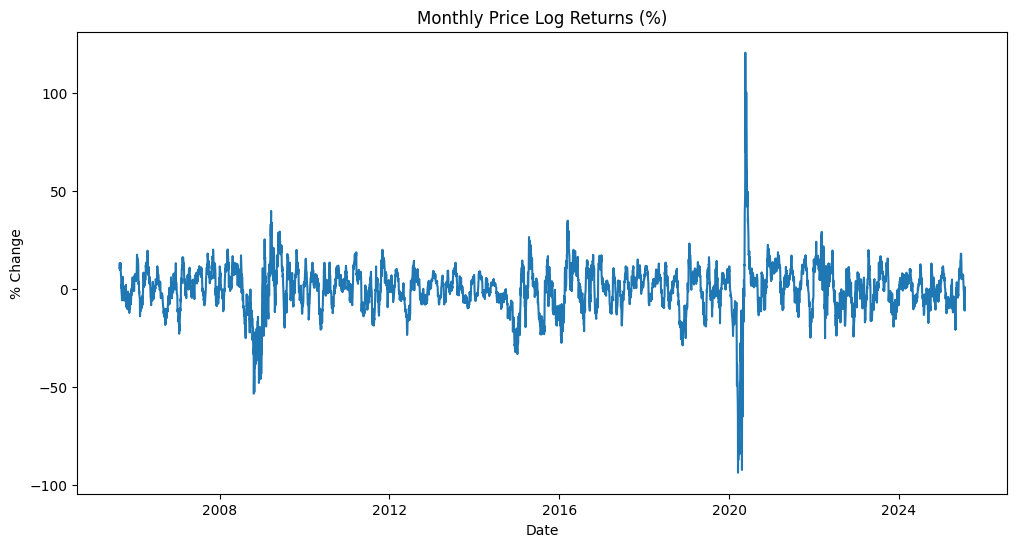

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df.date,df.mr*100)
plt.xlabel('Date')
plt.ylabel('% Change')
plt.title('Monthly Price Log Returns (%)')

To have a braoder idea of the returns over different time horizons we observe their distributions in the following chart 

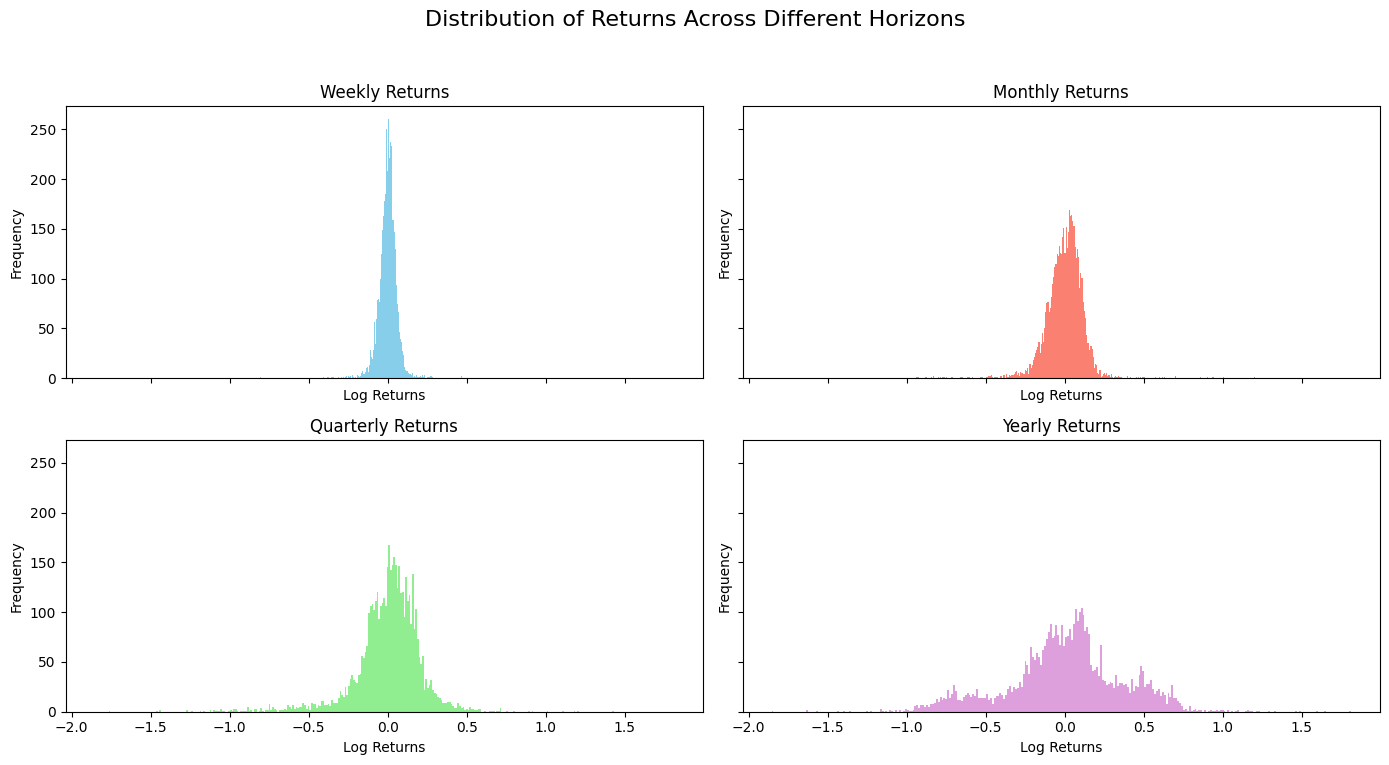

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

axs[0, 0].hist(df.wr.dropna(), bins=300, color='skyblue')
axs[0, 0].set_title('Weekly Returns')

axs[0, 1].hist(df.mr.dropna(), bins=300, color='salmon')
axs[0, 1].set_title('Monthly Returns')

axs[1, 0].hist(df.qr.dropna(), bins=300, color='lightgreen')
axs[1, 0].set_title('Quarterly Returns')

axs[1, 1].hist(df.yr.dropna(), bins=300, color='plum')
axs[1, 1].set_title('Yearly Returns')

# Shared labels
for ax in axs.flat:
    ax.set_xlabel('Log Returns')
    ax.set_ylabel('Frequency')

plt.suptitle('Distribution of Returns Across Different Horizons', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [28]:
# Weekly (wrv), Monthly (mrv), Quarterly (qrv) and Yearly (yrv) Rolling Volatility 

#based on daily returns!!! so it is day to day rolled over the periods cited above

df['wrv'] = df.dr.rolling(5).std()
df['mrv'] = df.dr.rolling(21).std()
df['qrv'] = df.dr.rolling(63).std()
df['yrv'] = df.dr.rolling(252).std()

rolling_vol = df[['wrv','mrv','qrv','yrv',]]
print(f'-------------- Main Statistics for Weekly (wr), Monthly (mr), Quarterly (qr), and Yearly (yr) Rolling Volatility ----------------')
rolling_vol.describe()

-------------- Main Statistics for Weekly (wr), Monthly (mr), Quarterly (qr), and Yearly (yr) Rolling Volatility ----------------


,wrv,mrv,qrv,yrv
count,5024.000000,5008.000000,4966.000000,4777.000000
mean,0.021173,0.022496,0.023230,0.024799
std,0.018416,0.016176,0.014997,0.012831
min,0.001539,0.006314,0.007509,0.010141
25%,0.011902,0.014885,0.016039,0.018067
50%,0.017422,0.018831,0.020496,0.020814
75%,0.024857,0.024989,0.024602,0.028014
max,0.371210,0.197646,0.134892,0.070178


Text(0.5, 1.0, 'Monthly (21 trading days) Rolling Volatility')

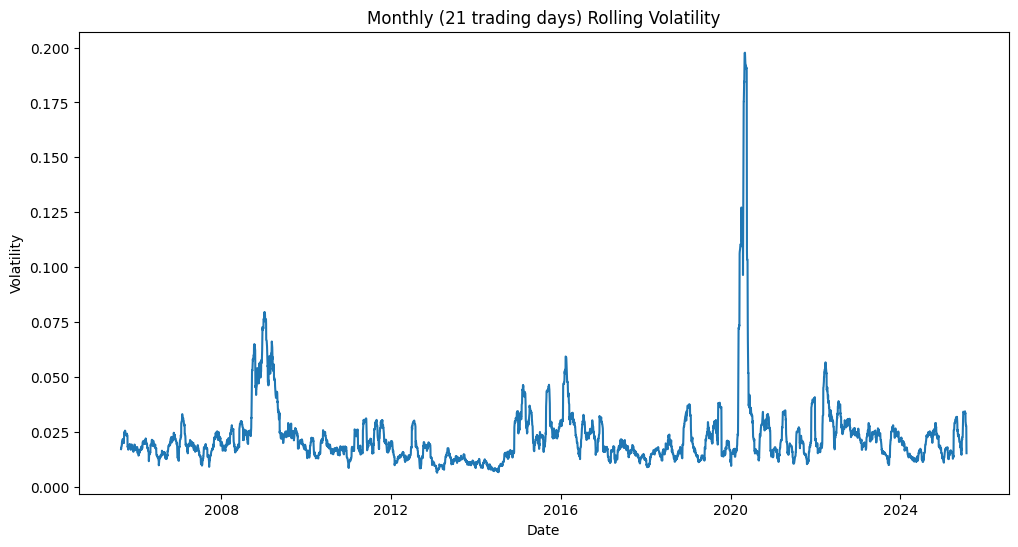

In [29]:
plt.figure(figsize=(12,6))
plt.plot(df.date,df.mrv)
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Monthly (21 trading days) Rolling Volatility')

I want to categorize periods based on the monthly (21 trading days) rolled volatility. To do so we calculate the tertiles (33%th and 66%th quantiles).

Low volatility iff < 33%th quantile
Medium volatility iff >= 33%th quantile and <66%th quantile
High volatility iff >=66%th quantile

The following plot shows how graphically teh data is categoried based on the verdical dotted lines!!!

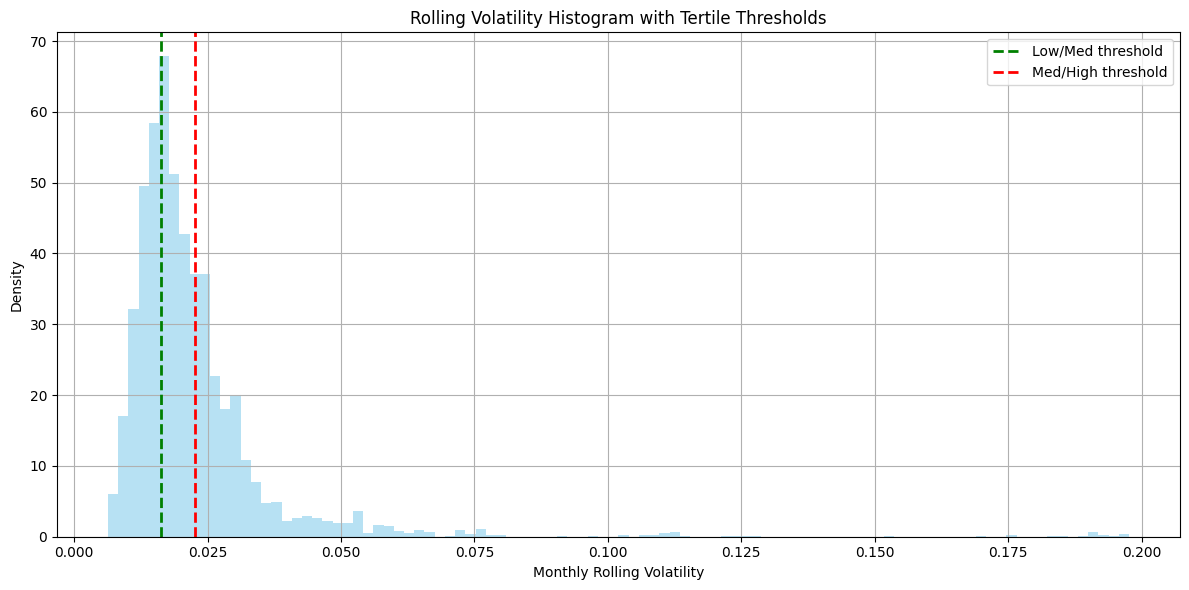

In [30]:
#calculating distribution tertiles
low_vol = df.mrv.quantile(0.33) #first tertile limit
high_vol = df.mrv.quantile(0.66) #second tertile limit

plt.figure(figsize=(12, 6))
plt.hist(df.mrv, bins=100, density=True, alpha=0.6, color='skyblue')
#adding tertiles barriers
plt.axvline(low_vol, color='green', linestyle='--', linewidth=2, label='Low/Med threshold')
plt.axvline(high_vol, color='red', linestyle='--', linewidth=2, label='Med/High threshold')
plt.title("Rolling Volatility Histogram with Tertile Thresholds")
plt.xlabel("Monthly Rolling Volatility")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Little parenthesis.... after all teh calcualtions we are going to have a lot of NaN due to rolling and long horizon returns calculations. Now the df is sufficiently big so we can drop these NaNs...

In [31]:
df = df.dropna()

In [32]:
#the fastest way to do it is this one... 
# ....otherwise a long and inefficient for loop + if, elif, else :)

df['vol_cat'] = pd.qcut(df.mrv, q = 3, labels=['low','medium','high'])

Now, this figure will be more useful later on.. right now let's just visualie it on a chart!

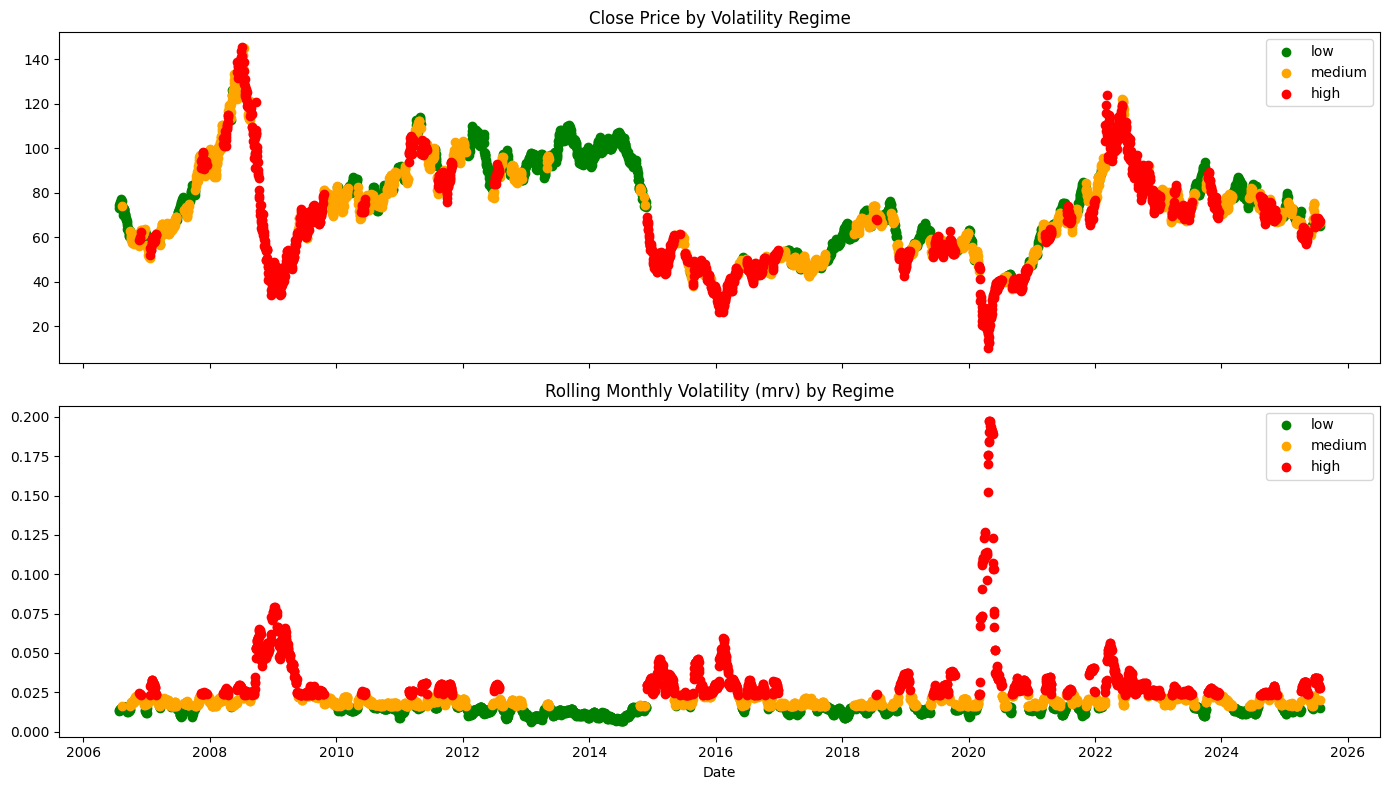

In [33]:
colors = {'low': 'green', 'medium': 'orange', 'high': 'red'}

# Create figure and axes
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Loop over categories and plot each segment separately
for cat, color in colors.items():
    segment = df[df['vol_cat'] == cat]
    
    # Plot close price
    axs[0].scatter(segment.date, segment['close'], color=color, label=cat, )
    
    # Plot rolling vol (mrv)
    axs[1].scatter(segment.date, segment['mrv'], color=color, label=cat)

# Add titles and legends
axs[0].set_title('Close Price by Volatility Regime')
axs[1].set_title('Rolling Monthly Volatility (mrv) by Regime')
axs[1].set_xlabel('Date')

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.show()


## Roll Yield Approximation

To analyze roll yield properly we would need differnt data. Indeed, the roll yield is defined as the return we get by rolling a futures contract overtime. This means closing the near-term contract and opening a longer-term contract. 

Now if the market is backwardation (F<S) we expect an inverted curve. Hence, rolling will ensure us selling the near term at higher price than the amount we are paying for the longer term contract. Hence the roll yield is positive (the opposite occurs in contango).

As we said, we don not have closing prices for each contract so we need a proxy or trying to find out the rolling date.

Now, for WTI crude futures the expiration is "3 business days before the 25th of the month preceeding the delivery month".

So for example the Aug 2025 contract will expire on the 22th July...hence the logic is the following one:

| 25th Falls On | Roll Date (3 Biz Days Before) |
| ------------- | ----------------------------- |
| Monday        | Wednesday prior (22nd)        |
| Tuesday       | Thursday prior (22nd)         |
| Wednesday     | Friday prior (22nd)           |
| Thursday      | Monday prior (22nd)           |
| Friday        | Tuesday prior (22nd)          |
| Saturday      | Wednesday prior (22nd)        |
| Sunday        | Wednesday prior (22nd)        |



### Extracting Roll Dates!

In [34]:
df.roll_flag = 0 #create roll_flag column and set it to 0 for each row
roll_dates = []

#...just in case
df['date'] = pd.to_datetime(df['date'])
#set date column as index for easier lookup
df = df.set_index('date')
#for each month, find the business day closest before the 25th, and roll 3 days before that

#each month is a string like "07-2023" or "12-2021" ....
all_months = df.index.to_period('M').unique()

for month in all_months:
    target_day = pd.Timestamp(f"{month}-25")
    if target_day in df.index:
        print(f'The target date is {target_day}')
    # If 25th not in index, find the previous closest date available
    else:
    #if not, select all teh possible date in this given month
        available_dates = df.loc[str(month)].index
    #remove all the ones after the 25th
        available_before_25 = available_dates[available_dates < target_day]
    #if not date exist (almost impossible but you never knowwww) skip this month
        if len(available_before_25) == 0:
            continue  
        #take as target day the day available before the 25th
        target_day = available_before_25[-1]
        print(f'During {month} the 25th was not a trading day, hence the rule picks {target_day} ')
    
    #find the index relative to the target day
    roll_day_index = df.index.get_loc(target_day)
    #if there are at least 3 days before target day
    if roll_day_index >= 3:
    #date the day 3 (business) days before target day
        roll_date = df.index[roll_day_index - 3]
        roll_dates.append(roll_date)

#flag them with roll_flag = =1
df['roll_flag'] = df.index.isin(roll_dates).astype(int)
#reset index if needed
df = df.reset_index()

The target date is 2006-08-25 00:00:00
The target date is 2006-09-25 00:00:00
The target date is 2006-10-25 00:00:00
During 2006-11 the 25th was not a trading day, hence the rule picks 2006-11-22 00:00:00 
During 2006-12 the 25th was not a trading day, hence the rule picks 2006-12-22 00:00:00 
The target date is 2007-01-25 00:00:00
During 2007-02 the 25th was not a trading day, hence the rule picks 2007-02-23 00:00:00 
During 2007-03 the 25th was not a trading day, hence the rule picks 2007-03-23 00:00:00 
The target date is 2007-04-25 00:00:00
The target date is 2007-05-25 00:00:00
The target date is 2007-06-25 00:00:00
The target date is 2007-07-25 00:00:00
During 2007-08 the 25th was not a trading day, hence the rule picks 2007-08-24 00:00:00 
The target date is 2007-09-25 00:00:00
The target date is 2007-10-25 00:00:00
During 2007-11 the 25th was not a trading day, hence the rule picks 2007-11-23 00:00:00 
During 2007-12 the 25th was not a trading day, hence the rule picks 2007-12-

Now, to double check we got the right rolling dates we can perform some extra inspections:

1. Check if rolling dates are more or less 30 days apart
2. Higher (than average) volatility
3. higher (than average) volume

This seems fair... so lets figure out if this is true :)

distance between rolling dates: check

Text(0.5, 0, 'Number of expired contracts')

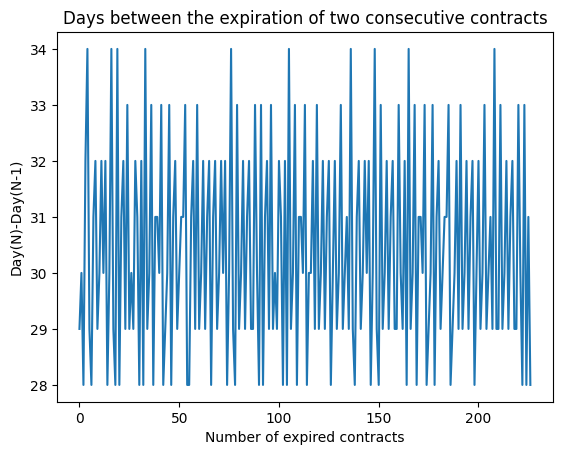

In [35]:
#list to store days distances
distances = []
#candidate roll dates
roll_dates = df[df.roll_flag == 1]['date'].tolist()
for i in range(1,len(roll_dates)):
    distance = (roll_dates[i]-roll_dates[i-1]).days
    distances.append(distance)


    #trying to checkc if rd in roll dates are 30 days apart

plt.plot(distances)
plt.title("Days between the expiration of two consecutive contracts")
plt.ylabel('Day(N)-Day(N-1)')
plt.xlabel('Number of expired contracts')

Visually we can see that this operation was well performed as on average the distance between the expiration fo two consecutive contracts is around 30 days! Great!

Let's start by graphically inspecting the volume

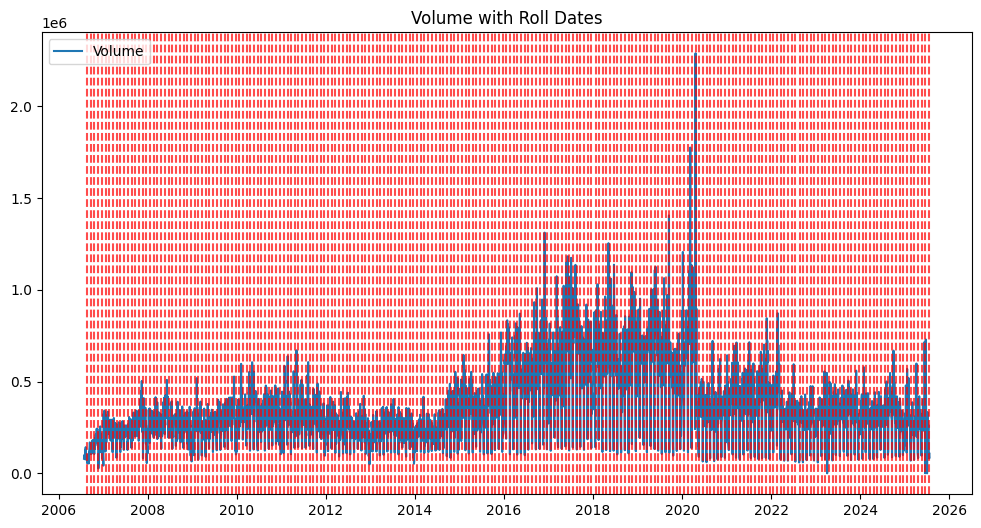

In [36]:
#plot volume and see graphically if it spikes 
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['volume'], label='Volume')
#highlight roll dates
for rd in df.loc[df['roll_flag'] == 1, 'date']:
    plt.axvline(rd, color='red', linestyle='--', alpha=0.7)

plt.title("Volume with Roll Dates")
plt.legend()
plt.show()

The chart is too noisy, hence it is better to go ahead with a more statistical approach!

We will create another flag column called roll_window. An observation falls in roll window if the corresponding date is +-X days from the probable roll date.

In [37]:
#days window (X)
window = 3 #3 days window
df['roll_window'] = 0

#find the index positions of roll dates
roll_idxs = df[df['roll_flag'] == 1].index

#for each roll date index, flag it and the 3 days before
for idx in roll_idxs:
    for i in range(max(0, idx - window), idx + 1):  # idx-3 to idx (inclusive)
        df.loc[i, 'roll_window'] = 1

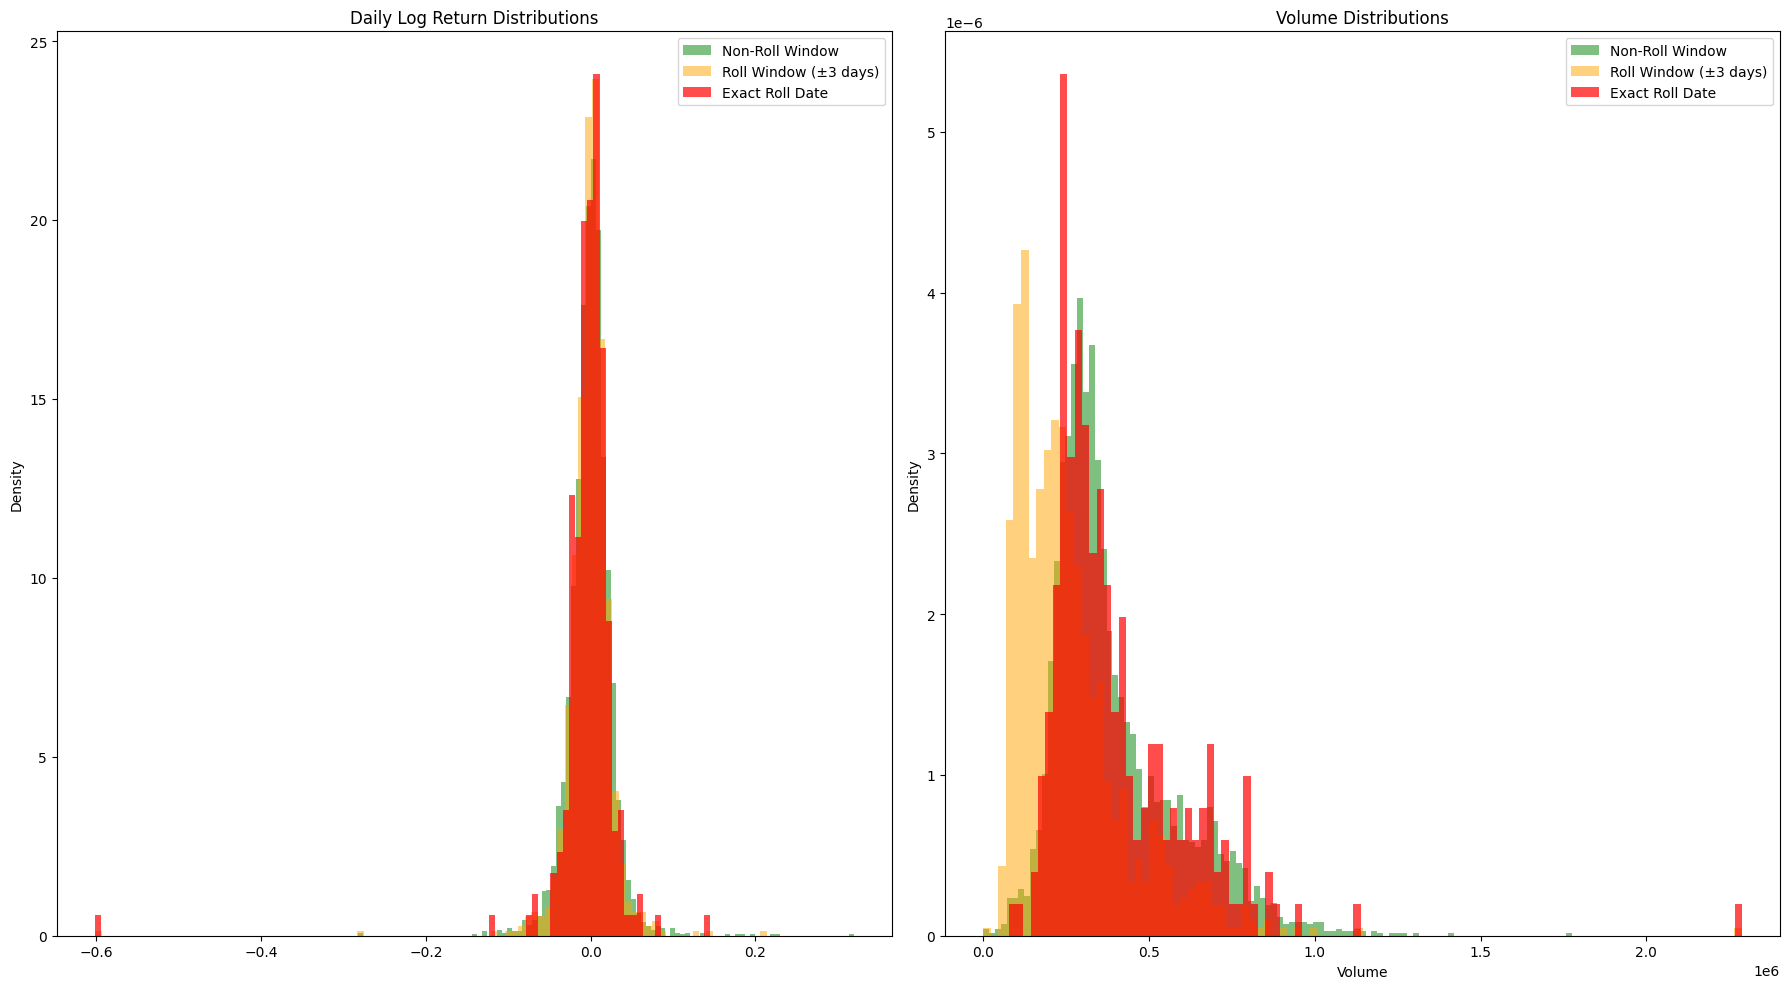

In [38]:
#extract returns
roll_flag_returns = df[df['roll_flag'] == 1]['dr']
roll_window_returns = df[df['roll_window'] == 1]['dr']
non_roll_returns = df[df['roll_window'] == 0]['dr']

#xtract volumes
roll_flag_volume = df[df['roll_flag'] == 1]['volume']
roll_window_volume = df[df['roll_window'] == 1]['volume']
non_roll_volume = df[df['roll_window'] == 0]['volume']

#plot
fig, axs = plt.subplots(1, 2, figsize=(18, 10), sharex=False)

# ---- TOP: Returns ----
axs[0].hist(non_roll_returns, bins=100, alpha=0.5, color='green', label='Non-Roll Window', density=True)
axs[0].hist(roll_window_returns, bins=100, alpha=0.5, color='orange', label='Roll Window (±3 days)', density=True)
axs[0].hist(roll_flag_returns, bins=100, alpha=0.7, color='red', label='Exact Roll Date', density=True)
axs[0].set_title("Daily Log Return Distributions")
axs[0].set_ylabel("Density")
axs[0].legend()

# ---- BOTTOM: Volumes ----
axs[1].hist(non_roll_volume, bins=100, alpha=0.5, color='green', label='Non-Roll Window', density=True)
axs[1].hist(roll_window_volume, bins=100, alpha=0.5, color='orange', label='Roll Window (±3 days)', density=True)
axs[1].hist(roll_flag_volume, bins=100, alpha=0.7, color='red', label='Exact Roll Date', density=True)
axs[1].set_title("Volume Distributions")
axs[1].set_xlabel("Volume")
axs[1].set_ylabel("Density")
axs[1].legend()

plt.tight_layout()
plt.show()

In [39]:
# Compare stats
print("Returns Std:")
print("Roll Flag: ", roll_flag_returns.std())
print("Roll Window: ", roll_window_returns.std())
print("Non-Roll: ", non_roll_returns.std())

print("\nVolumes Mean:")
print("Roll Flag: ", roll_flag_volume.mean())
print("Roll Window: ", roll_window_volume.mean())
print("Non-Roll: ", non_roll_volume.mean())


Returns Std:
Roll Flag:  0.046507817465632185
Roll Window:  0.03262614057483257
Non-Roll:  0.0268010685166891

Volumes Mean:
Roll Flag:  402814.1666666667
Roll Window:  261182.3278508772
Non-Roll:  396601.8478654593


What do we observe?

Volatility is clearly higher around roll dates (especially on the exact roll day).
That aligns with the idea that uncertainty and repositioning spike around contract expiration.

- On roll dates, many traders shift positions, causing price noise.
- During the 3-day roll window, volatility is elevated but less extreme.
- Outside those windows, markets are calmer.

Unfortunately, the volume does not confirm our thesis. While volume on rolling days is (on average) slightly greater than on other days, the volume on the 3 days before the (candidate) rolling dates is much smaller than average. 

Tho the number of observations in the 3 subsets it is not statistically comparable. Let's try to set the number of obs in each sample equal to the smallest sample size and randomply pick observations from the other two remaining distributions. 

Then recompute the statistics and add box plots for easy visualization

In [40]:
#seed for reproducibility
np.random.seed(42)

#smallest group size
min_len = min(len(roll_flag_volume), len(roll_window_volume), len(non_roll_volume))

#sample equal-sized subsets
vol_data = pd.DataFrame({
    'category': ['Roll Flag'] * min_len + ['Roll Window'] * min_len + ['Non-Roll'] * min_len,
    'volume': pd.concat([
        roll_flag_volume.sample(min_len),
        roll_window_volume.sample(min_len),
        non_roll_volume.sample(min_len)]),
})

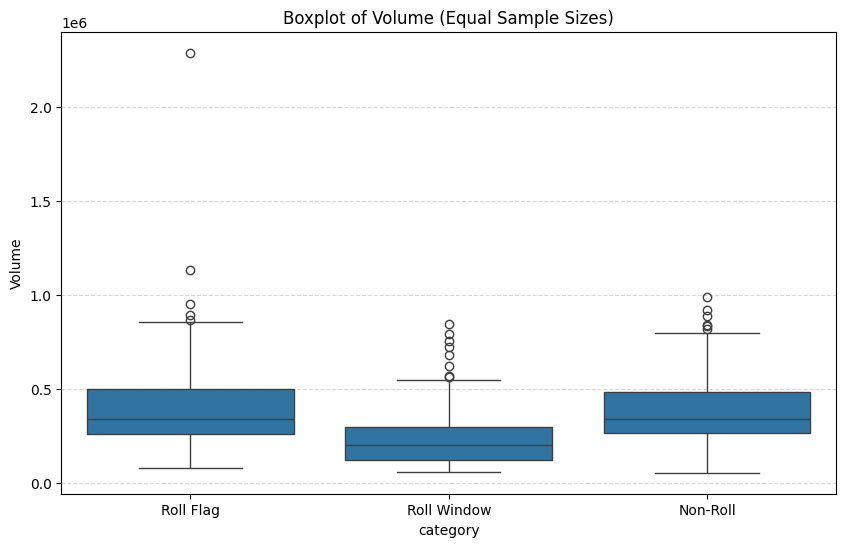

In [41]:
#boxplotsssss
plt.figure(figsize=(10, 6))
sns.boxplot(x='category', y='volume', data=vol_data)
plt.title("Boxplot of Volume (Equal Sample Sizes)")
plt.ylabel("Volume")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()


Even after random resampling the distributions follow what we said before. This has to be further investigated.

What can we look at?
- Is the volume spiking the 3 days after the roll instead?
- Is the volume choppy or hihgly volatile around the roll window

In [42]:
#rename existing roll_window to roll_window_bf
df.rename(columns={'roll_window': 'roll_window_bf'}, inplace=True)

#create roll_window_af and initialize to 0
df['roll_window_af'] = 0

for idx in roll_idxs:
    # Flag 3 days after roll date (inclusive)
    for i in range(idx, min(len(df) - 1, idx + window) + 1):
        df.loc[i, 'roll_window_af'] = 1

In [43]:

#again... calculalte the ret.std and vol.mean

#extract returns
roll_flag_returns = df[df['roll_flag'] == 1]['dr']
roll_window_af_returns = df[df['roll_window_af'] == 1]['dr']
roll_window_bf_returns = df[df['roll_window_bf'] == 1]['dr']
non_roll_returns = df[(df['roll_window_bf'] == 0) & (df['roll_window_af'] == 0)]['dr']

#xtract volumes
roll_flag_volume = df[df['roll_flag'] == 1]['volume']
roll_window_af_volume = df[df['roll_window_af'] == 1]['volume']
roll_window_bf_volume = df[df['roll_window_bf'] == 1]['volume']
non_roll_volume = df[(df['roll_window_bf'] == 0) & (df['roll_window_af'] == 0)]['volume']

# Compare stats
print("Returns Std:")
print("Roll Flag: ", roll_flag_returns.std())
print("Roll Window After: ", roll_window_af_returns.std())
print("Roll Window Before: ", roll_window_bf_returns.std())
print("Non-Roll: ", non_roll_returns.std())

print("\nVolumes Mean:")
print("Roll Flag: ", roll_flag_volume.mean())
print("Roll Window After: ", roll_window_af_volume.mean())
print("Roll Window Before: ", roll_window_bf_volume.mean())
print("Non-Roll: ", non_roll_volume.mean())

Returns Std:
Roll Flag:  0.046507817465632185
Roll Window After:  0.0338217111280837
Roll Window Before:  0.03262614057483257
Non-Roll:  0.026451042550297423

Volumes Mean:
Roll Flag:  402814.1666666667
Roll Window After:  379613.8311403509
Roll Window Before:  261182.3278508772
Non-Roll:  401917.6227601383


In [44]:
type(df.date)

pandas.core.series.Series

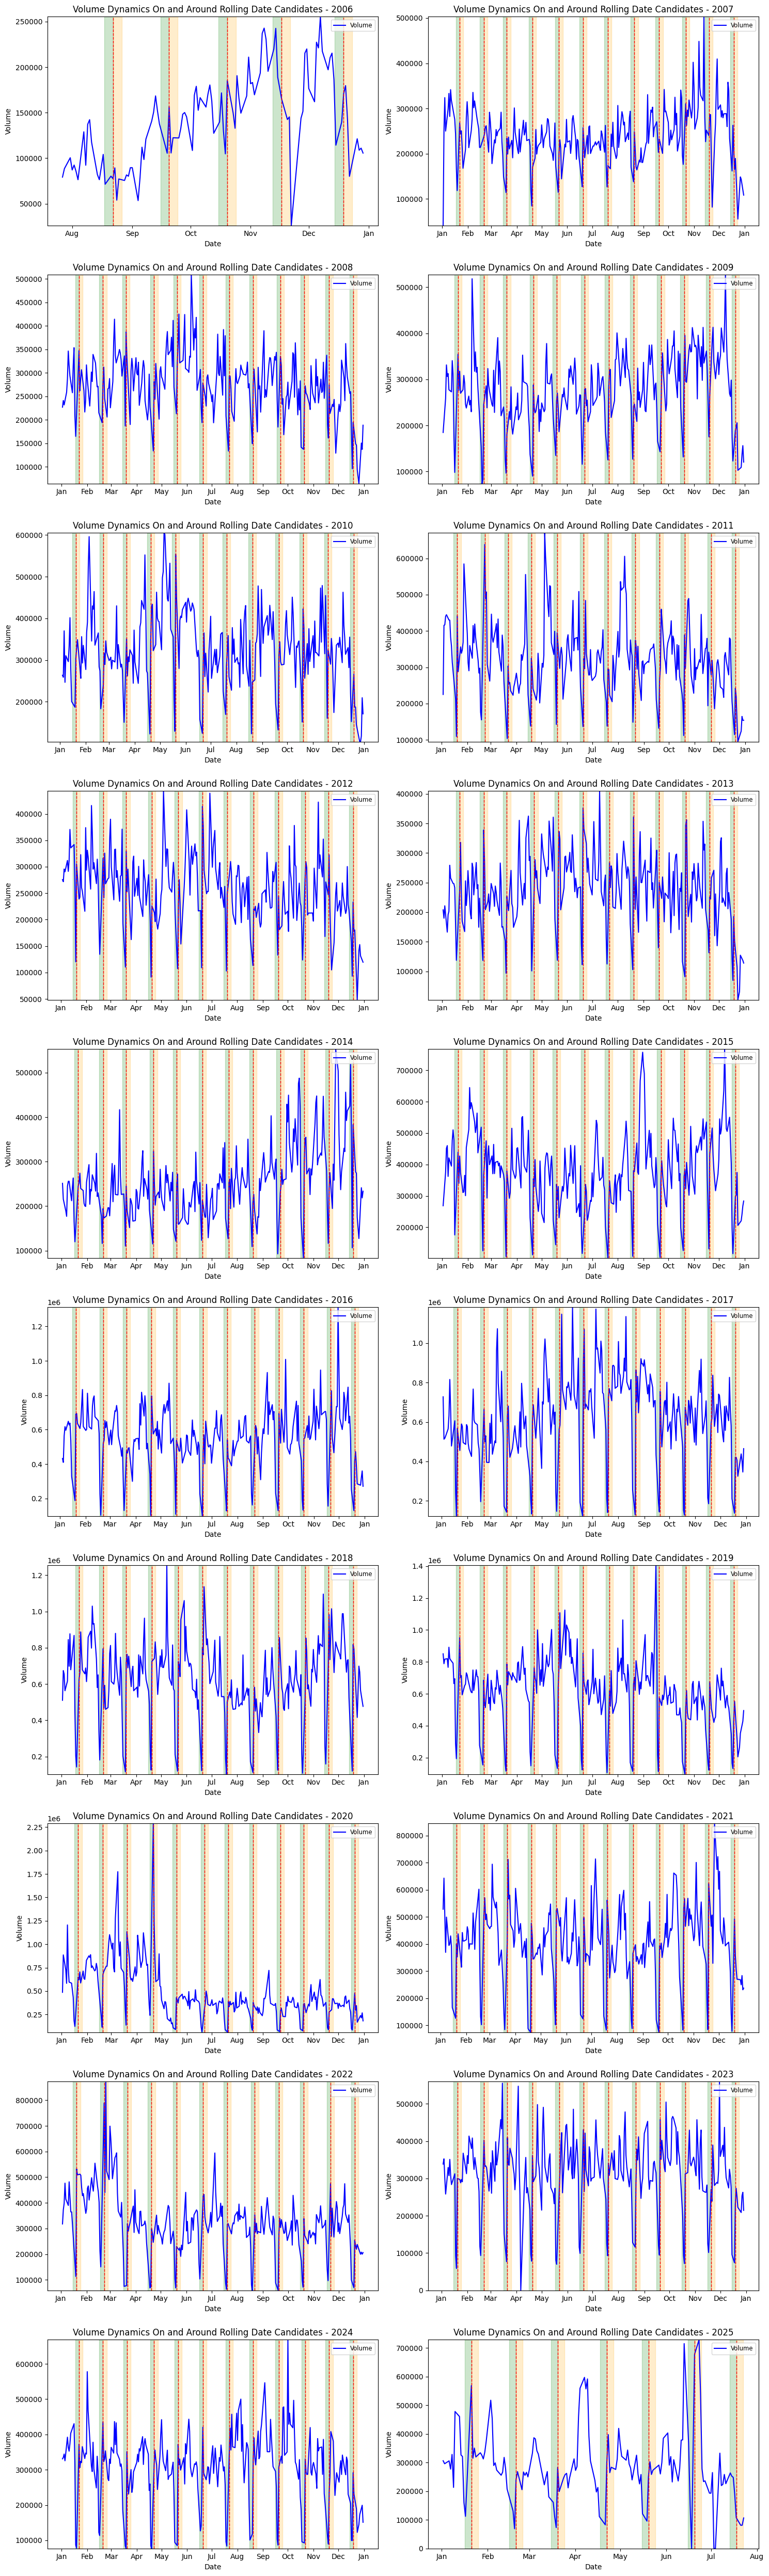

In [45]:
#copy the df for plotting purposes
df_plot = df.copy()
df_plot = df_plot.set_index('date')
#unique years in data
years = sorted(df_plot.index.year.unique())

# Prepare figure layout
nrows = (len(years) + 1) // 2  # 2 cols layout
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(15, 5 * nrows))

if nrows == 1:
    axes = axes.reshape(1, 2)  # ensure axes is 2D

for i, year in enumerate(years):
    ax = axes[i // 2, i % 2]
    
    #filter data for the year
    df_year = df_plot[df_plot.index.year == year]
    #volume line
    ax.plot(df_year.index, df_year['volume'], label='Volume', color='blue')
    #min-max normalize volume on the y axis for each year just to have a better visual
    vol_min = df_year['volume'].min()
    vol_max = df_year['volume'].max()
    ax.set_ylim(vol_min, vol_max)
    
    #key dates
    roll_dates = df_year[df_year['roll_flag'] == 1].index
    bf_dates = df_year[df_year['roll_window_bf'] == 1].index
    af_dates = df_year[df_year['roll_window_af'] == 1].index
    
    #vertical lines for roll dates
    for rd in roll_dates:
        ax.axvline(rd, color='red', linestyle='--', linewidth=1)  # label removed
    
    #before windows with semi-transparent green vertical spans
    for bf in roll_dates:
        start_bf = bf - pd.Timedelta(days=3*1.5)  # approx 3 business days back (adjust as needed)
        end_bf = bf
        ax.axvspan(start_bf, end_bf, color='green', alpha=0.2)  # label removed
    
    #after windows with semi-transparent orange vertical spans
    for af in roll_dates:
        start_af = af
        end_af = af + pd.Timedelta(days=3*1.5)  # approx 3 business days forward
        ax.axvspan(start_af, end_af, color='orange', alpha=0.2)  # label removed

    ax.set_title(f'Volume Dynamics On and Around Rolling Date Candidates - {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


Finally we found a really interesting and repeated pattern.

- Volume drops before the roll date, maybe traders reduce activity anticipating the roll,
- Then volume starts increasing after the roll date,
- And peaks between two consecutive roll dates — possibly as positions build up again in the new front-month contract.

### Playing with Single Contracts

1. Term Structure and Roll Yield Analysis
- Term Structure: Compare prices across different contracts (front-month, second-month, etc.) to analyze contango vs backwardation dynamics.
- Roll Yield: Calculate the return you get from rolling contracts forward — useful for understanding costs or benefits of holding futures.
2. Individual Contract Volatility & Volume Dynamics
- Study how volatility and volume evolve within a single contract’s life, from listing to expiration.
- See if volatility patterns change closer to expiry or in certain seasons.
3. Seasonality and Calendar Effects
- Explore seasonal patterns in prices, volatility, or volume within individual contracts.
- Identify any calendar anomalies like "January effect" or monthly roll-related patterns.
4. Price Discovery and Lead-Lag Relationships
- Compare how price changes in the front-month lead or lag changes in second or third-month contracts.
- Could be useful to identify where the market “anchors” price discovery.
5. Return and Risk Metrics per Contract
- Calculate risk-adjusted returns, drawdowns, Sharpe ratios for each contract.
- Assess how these metrics vary across contracts and over time.
6. Spread Analysis
- Once you have individual contract prices, you can calculate spreads between contracts (e.g., front-month minus second-month).
- Spreads can be traded or used as indicators of market sentiment and supply/demand.
7. Event Study
- Analyze how contracts react around key fundamental events (inventory reports, geopolitical news).
- See if reactions differ by contract maturity.

First we need to create a new column for the contract code using the CME-style contract codes.

Contract codes are made of:

- "CL" (WTI base code)
- Month code: {'F': Jan, 'G': Feb, ..., 'Z': Dec}
- Last two digits of the year

| Month | Code |
| ----- | ---- |
| Jan   | F    |
| Feb   | G    |
| Mar   | H    |
| Apr   | J    |
| May   | K    |
| Jun   | M    |
| Jul   | N    |
| Aug   | Q    |
| Sep   | U    |
| Oct   | V    |
| Nov   | X    |
| Dec   | Z    |


In [46]:
#month code map (CME convention)
month_code_map = {
    1: 'F', 2: 'G', 3: 'H', 4: 'J', 5: 'K', 6: 'M',
    7: 'N', 8: 'Q', 9: 'U', 10: 'V', 11: 'X', 12: 'Z'
}

#create the contract_id column
df.contract_id = None

#loop over each period between consecutive roll flags
for i, start_idx in enumerate(roll_idxs):
    #get the index of the next contract
    if i+1 < len(roll_idxs):
        end_idx = roll_idxs[i+1]
    else:
        end_idx = len(df)
    #get current roll date
    roll_date = df.loc[start_idx].date
    #get the CME code
    roll_month = roll_date.month
    month_code = month_code_map[roll_month]
    year_code = str(roll_date.year)[-2:]
    contract_code = "CL" + month_code + year_code

    #assing the extracted code to the corresponding contract 
    df.loc[start_idx:end_idx-1,'contract_id'] = contract_code

#drop the first observations as no flag is observed before a given number of days
df = df.dropna()

In [47]:
#term structure dataframe
dfts = df.pivot(index='date',columns='contract_id',values='close')
dfts

contract_id,CLF07,CLF08,CLF09,CLF10,CLF11,CLF12,CLF13,CLF14,CLF15,CLF16,...,CLZ15,CLZ16,CLZ17,CLZ18,CLZ19,CLZ20,CLZ21,CLZ22,CLZ23,CLZ24
date,,,,,,,,,,,,,,,,,,,,,
2006-08-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-08-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-08-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
